In [ ]:
!pip install pillow
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.datasets import LFWPairs
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
import os
from itertools import islice
import torch.nn as nn
import time
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
torch.manual_seed(2)
random.seed(2)
np.random.seed(2)
drive.mount('/content/drive')

lfw_dataset_folder = "/content/drive/MyDrive/lfwa/lfw2/lfw2"
train_txt_path = "/content/sample_data/pairsDevTrain.txt"
test_txt_path = "/content/sample_data/pairsDevTest.txt"


with open(train_txt_path, "r") as file:
    train_subjects = file.read().splitlines()

with open(test_txt_path, "r") as file:
    test_subjects = file.read().splitlines()

train_subjects = train_subjects[1:]
test_subjects= test_subjects[1:]

train_subjects_cleaned = [entry.replace('\t', ' ') for entry in train_subjects]
test_subjects_cleaned = [entry.replace('\t', ' ') for entry in test_subjects]

train_subjects_cleaned, val_subjects_cleaned = train_test_split(train_subjects_cleaned, test_size=0.1, random_state=42)

Mounted at /content/drive


In [ ]:
def extract_names_list(entries):
    """
    Extracts names from a list of entries, where each entry is a string containing
    space-separated words or numbers. Each entry represents a person's name along
    with the image number they belong to.

    Parameters:
    entries (list): A list of strings where each string represents an entry
                  containing names and numbers. Each entry corresponds
                  to a person's name along with the image number they belong to.

    Returns:
    list: A list of lists where each inner list contains the
    extracted names and numbers from the corresponding entry.
    """
    result_list = []
    for entry in entries:
        parts = entry.split()
        names =  [part if part.isdigit() else part for part in parts]
        result_list.append(names)
    return result_list

In [ ]:
torch.manual_seed(2)
random.seed(2)
np.random.seed(2)
class LFWDataset(Dataset):
    """
    Dataset class for loading images from the Labeled Faces in the Wild (LFW) dataset.

    Parameters:
    entries (list of list): A list of lists where each inner list represents information
                          about image pairs. For positive pairs, each inner list contains
                          three elements: the name of the person, the image number for the
                          first image, and the image number for the second image. For negative
                          pairs, each inner list contains four elements: the name and image
                          number for the first person, and the name and image number for the
                          second person.

    Methods:
    __len__(): Returns the total number of entries in the dataset.
    __getitem__(idx): Retrieves the images and label corresponding to the given index.

    Returns:
    tuple: A tuple containing the images of the pair, and a label indicating whether
          the pair is positive (1) or negative (0).
    """

    def __init__(self, folder_path, entries, transform=None):
        self.folder_path = folder_path
        self.entries = entries
        self.transform = transforms.Compose([
              transforms.Grayscale(),
              transforms.Resize((105, 105)),
              transforms.ToTensor()
            ])

    def __len__(self):
      return len(self.entries)

    def __getitem__(self, idx):
        entry = self.entries[idx]
        if len(entry) == 3:
            is_positive = True
        else:
          is_positive = False


        image_paths = []
        if is_positive:
          name1, digit1, digit2 = entry
          image_path1 = os.path.join(self.folder_path, f"{name1}/{name1}_{int(digit1):04d}.jpg")
          image_path2 = os.path.join(self.folder_path, f"{name1}/{name1}_{int(digit2):04d}.jpg")
          image_paths.extend([image_path1, image_path2])

        else:
          name1, digit1, name2, digit2 = entry
          image_path1 = os.path.join(self.folder_path, f"{name1}/{name1}_{int(digit1):04d}.jpg")
          image_path2 = os.path.join(self.folder_path, f"{name2}/{name2}_{int(digit2):04d}.jpg")
          image_paths.extend([image_path1, image_path2])


        for name, digit in zip(entry[::2], entry[1::2]):
            image_path = os.path.join(self.folder_path, f"{name}/{name}_{int(digit):04d}.jpg")
            image_paths.append(image_path)

        images = [Image.open(image_path).convert('L') for image_path in image_paths]
        if self.transform:
            images = [self.transform(image) for image in images]
        if is_positive:
          return (images[0], images[1], 1)
        else:
          return (images[0], images[1], 0)

In [ ]:
torch.manual_seed(2)
random.seed(2)
np.random.seed(2)
train_subjects_cleaned_lst = extract_names_list(train_subjects_cleaned)
val_subjects_cleaned_lst = extract_names_list(val_subjects_cleaned)
test_subjects_cleaned_lst = extract_names_list(test_subjects_cleaned)

train_dataset = LFWDataset(lfw_dataset_folder, train_subjects_cleaned_lst)
val_dataset = LFWDataset(lfw_dataset_folder, val_subjects_cleaned_lst)
test_dataset = LFWDataset(lfw_dataset_folder, test_subjects_cleaned_lst)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


count_length_3_train = sum(1 for sublist in train_subjects_cleaned_lst if len(sublist) == 3)
count_length_4_train= sum(1 for sublist in train_subjects_cleaned_lst if len(sublist) == 3)

count_length_3_val = sum(1 for sublist in val_subjects_cleaned_lst if len(sublist) == 3)
count_length_4_val= sum(1 for sublist in val_subjects_cleaned_lst if len(sublist) == 3)

count_length_3_test = sum(1 for sublist in test_subjects_cleaned_lst if len(sublist) == 3)
count_length_4_test= sum(1 for sublist in test_subjects_cleaned_lst if len(sublist) == 3)

print('train size',len(train_subjects_cleaned_lst))
print('positive samples in train',count_length_3_train)
print('negative samples in train',count_length_4_train)


print('Validation size',len(val_subjects_cleaned_lst))
print('positive samples in validation',count_length_3_val)
print('negative samples in validation',count_length_4_val)


print('Validation size',len(test_subjects_cleaned_lst))
print('positive samples in validation',count_length_3_test)
print('negative samples in train',count_length_4_test)

train size 1980
positive samples in train 979
negative samples in train 979
Validation size 220
positive samples in validation 121
negative samples in validation 121
Validation size 1000
positive samples in validation 500
negative samples in train 500


In [ ]:
class Flatten(nn.Module):
    """
    Module class for flattening input tensors.

    Attributes:
    None

    Methods:
    forward(input): Flattens the input tensor.

    Returns:
    torch.Tensor: A flattened tensor.
    """
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
torch.manual_seed(2)
random.seed(2)
np.random.seed(2)
def init_weights(m):
    """
    Initializes the weights of a neural network module.

    Parameters:
    m (torch.nn.Module): The neural network module for which weights are to be initialized.

    Returns:
    None
    """
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight, mean=0.0, std=1e-2)
        if m.bias is not None:
          nn.init.normal_(m.bias, mean=0.5, std=1e-2)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=2e-1)
        if m.bias is not None:
          nn.init.normal_(m.bias, mean=0.5, std=1e-2)

In [ ]:
def score(model, data_loader):
    """
    Evaluate the performance of a model on a given dataset.

    This function calculates the average loss and accuracy of the model
    on the dataset provided by the data loader.

    Parameters:
    model (torch.nn.Module): The neural network model to be evaluated.
    data_loader (torch.utils.data.DataLoader): The data loader containing the dataset
                                              on which the model's performance is evaluated.

    Returns:
    tuple: A tuple containing the average loss and accuracy of the model on the dataset.
    """
    model.eval()
    criterion = nn.BCELoss()
    avgerage_accuracy, avgerage_loss = 0, 0
    for images1, images2, labels in data_loader:
        images1, images2, labels = images1.cuda(), images2.cuda(),  labels.cuda()
        results = model(images1, images2)
        loss = criterion(results.float(), labels.unsqueeze(1).float())
        avgerage_loss += loss.item()
        results = torch.flatten(results)
        output = torch.where(results > 0.5, torch.tensor(1.0).cuda(), torch.tensor(0.0).cuda()).float()
        avgerage_accuracy += (output == labels).sum()
    loss = avgerage_loss / len(data_loader)
    accuracy = avgerage_accuracy / len(data_loader.dataset)
    return loss, accuracy

In [ ]:
def main(network,batch_size,learning_rate,num_epochs,optimizer_input):
  """
  Train a Siamese network model on a dataset.

  This function trains a Siamese network model using the specified parameters
  such as the network architecture, batch size, learning rate, number of epochs, and optimizer.

  Parameters:
  network (torch.nn.Module): The Siamese network model to be trained.
  batch_size (int): The batch size for training.
  learning_rate (float): The learning rate for optimization.
  num_epochs (int): The number of epochs for training.
  optimizer_input (str): The optimizer to be used for optimization.
                        It can be either 'Adam' or 'SGD'.

  Returns:
  tuple: A tuple containing the training loss history, validation loss history,
        training accuracy history, validation accuracy history, epoch numbers,
        and the trained Siamese model.
  """
  siamese_model = network.cuda()
  batch_size = batch_size
  learning_rate = learning_rate
  num_epochs = num_epochs

  torch.manual_seed(2)
  random.seed(2)
  np.random.seed(2)


  if optimizer_input == 'Adam':
    optimizer = torch.optim.Adam(siamese_model.parameters(), lr=learning_rate,weight_decay=0.01)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
  else:
    optimizer = torch.optim.SGD(siamese_model.parameters(), lr=learning_rate,momentum=0.7)
  criterion = nn.BCELoss()
  patience = 10
  best_val_loss = float('inf')
  early_stop_counter = 0



  train_loss_history = []
  val_loss_history = []
  val_accuracy_history = []
  train_accuracy_history = []
  epoches = []

  x = time.time()
  for epoch in range(num_epochs):
      siamese_model.train()
      running_train_loss = 0.0
      for batch_idx, (images1, images2, labels) in enumerate(train_loader):
        outputs = siamese_model(images1.cuda(), images2.cuda())
        loss = criterion(outputs, labels.float().cuda().view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()


      train_loss, train_accuracy = score(siamese_model,train_loader)
      train_loss_history.append(train_loss)
      train_accuracy_history.append(float(train_accuracy))

      val_loss, val_accuracy = score(siamese_model,val_loader)
      val_loss_history.append(val_loss)
      val_accuracy_history.append(float(val_accuracy))

      epoches.append(epoch+1)
      print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")

      if val_loss < best_val_loss:
          best_val_loss = val_loss
          early_stop_counter = 0
      else:
          early_stop_counter += 1
          if early_stop_counter >= patience:
              print(f"Early stopping at epoch {epoch+1} as validation loss didn't improve for {patience} epochs.")
              break

  y = time.time()
  return train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history, epoches, siamese_model

# Experiment 1- Siamese Neural Networks, Adam optimizer

In [ ]:
torch.manual_seed(2)
random.seed(2)
np.random.seed(2)
class SiameseModel(nn.Module):
    def __init__(self):
        super(SiameseModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=10, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=1),
            nn.ReLU()
        )

        self.flatten = Flatten()
        self.fc1 = nn.Linear(9216, 32, bias=True)
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        self.apply(init_weights)

    def forward(self, one, two):
        image1 = self.conv1(one)
        image1 = self.conv2(image1)
        image1 = self.conv3(image1)
        image1 = self.conv4(image1)
        image1 = self.flatten(image1)
        image1 = self.fc1(image1)

        image2 = self.conv1(two)
        image2 = self.conv2(image2)
        image2 = self.conv3(image2)
        image2 = self.conv4(image2)
        image2 = self.flatten(image2)
        image2 = self.fc1(image2)

        final = self.fc2(torch.abs(image1 - image2))
        final = self.sigmoid(final)
        return final

In [ ]:
train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist,epoches,model = main(SiameseModel(), 64, 0.001, 100,'Adam')

Epoch [1/100], Train Loss: 0.7198657220409762, Train Accuracy: 0.5030303001403809, Val Loss: 0.6965846866369247, Val Accuracy: 0.550000011920929
Epoch [2/100], Train Loss: 0.6434364030438084, Train Accuracy: 0.6191919445991516, Val Loss: 0.6727925091981888, Val Accuracy: 0.5772727131843567
Epoch [3/100], Train Loss: 0.6307448456364293, Train Accuracy: 0.6580808162689209, Val Loss: 0.6367037445306778, Val Accuracy: 0.6272727251052856
Epoch [4/100], Train Loss: 0.5950030030742768, Train Accuracy: 0.686363697052002, Val Loss: 0.6934743970632553, Val Accuracy: 0.6045454144477844
Epoch [5/100], Train Loss: 0.6047974632632348, Train Accuracy: 0.6954545974731445, Val Loss: 0.6353105455636978, Val Accuracy: 0.6818181872367859
Epoch [6/100], Train Loss: 0.5399357282346294, Train Accuracy: 0.7303030490875244, Val Loss: 0.6692610532045364, Val Accuracy: 0.6409090757369995
Epoch [7/100], Train Loss: 0.49826688439615313, Train Accuracy: 0.7727273106575012, Val Loss: 0.6624682769179344, Val Accuracy

In [ ]:
print(SiameseModel())

SiameseModel(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
  )
  (flatten): Flatten()
  (fc1): Linear(in_features=9216, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


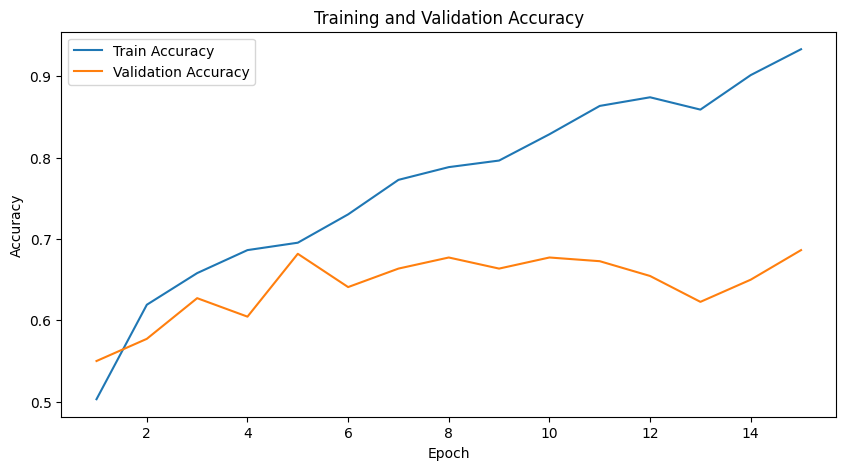

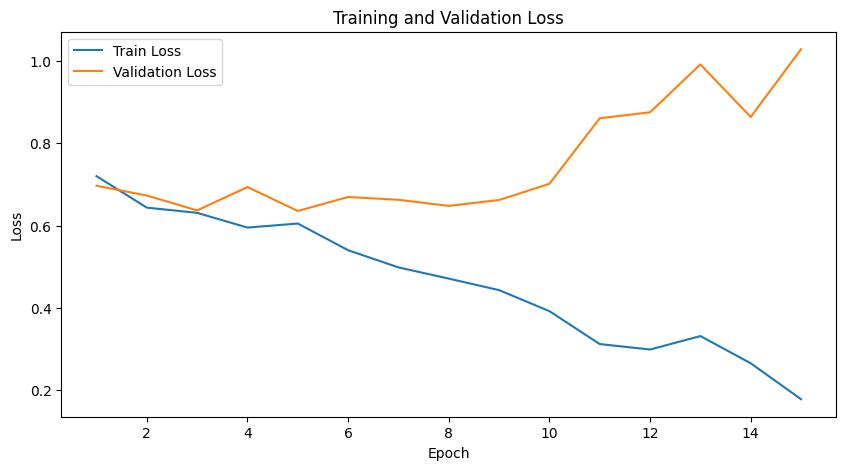

In [ ]:
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5))
plt.plot(epoches, train_acc_hist, label='Train Accuracy')
plt.plot(epoches, val_acc_hist, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()





warnings.filterwarnings("ignore")
plt.figure(figsize=(10,5))
plt.plot(epoches, train_loss_hist, label='Train Loss')
plt.plot(epoches,val_loss_hist, label="Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
torch.manual_seed(25)
random.seed(25)
np.random.seed(25)
test_loss, test_accuracy = score(model,test_loader)
print("test loss",test_loss)
print("test accuracy",float(test_accuracy))

test loss 1.0530509315431118
test accuracy 0.659000039100647


#Expierement 2- Siamese Neural Networks, SGD optimizer

In [ ]:
#original_network
train_loss_hist_2, val_loss_hist_2, train_acc_hist_2, val_acc_hist_2,epoches_2,model2 = main(SiameseModel(), 64, 0.001, 100,'SGD')

Epoch [1/100], Train Loss: 0.7257576354088322, Train Accuracy: 0.49444445967674255, Val Loss: 0.692498192191124, Val Accuracy: 0.550000011920929
Epoch [2/100], Train Loss: 0.716461843059909, Train Accuracy: 0.49444445967674255, Val Loss: 0.6889159828424454, Val Accuracy: 0.550000011920929
Epoch [3/100], Train Loss: 0.7042748120523268, Train Accuracy: 0.49848487973213196, Val Loss: 0.684906929731369, Val Accuracy: 0.5545454621315002
Epoch [4/100], Train Loss: 0.6890382286041014, Train Accuracy: 0.5378788113594055, Val Loss: 0.6826479882001877, Val Accuracy: 0.5772727131843567
Epoch [5/100], Train Loss: 0.6765103993877288, Train Accuracy: 0.5732323527336121, Val Loss: 0.6854362487792969, Val Accuracy: 0.5363636016845703
Epoch [6/100], Train Loss: 0.66986124361715, Train Accuracy: 0.586363673210144, Val Loss: 0.6909801214933395, Val Accuracy: 0.5181818008422852
Epoch [7/100], Train Loss: 0.6639848351478577, Train Accuracy: 0.5893939733505249, Val Loss: 0.688516303896904, Val Accuracy: 0.5

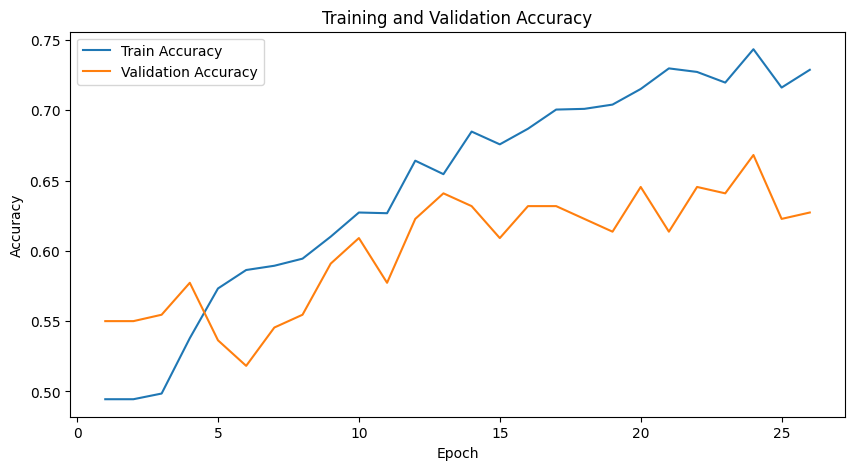

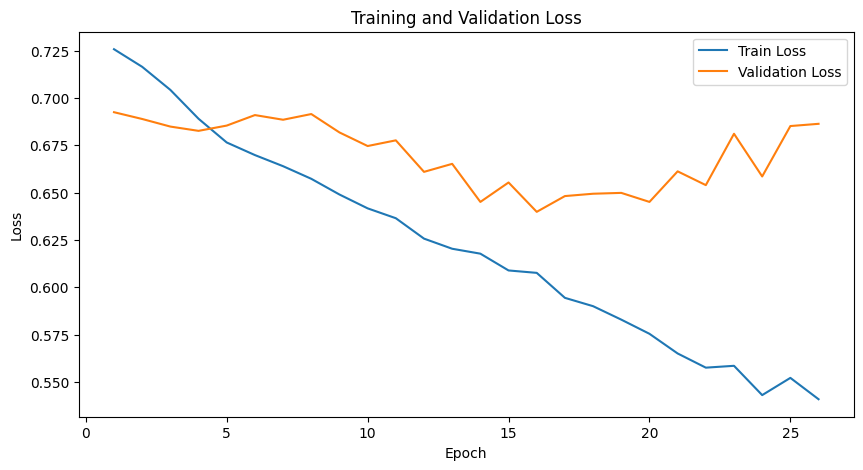

In [ ]:
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5))
plt.plot(epoches_2, train_acc_hist_2, label='Train Accuracy')
plt.plot(epoches_2, val_acc_hist_2, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()





warnings.filterwarnings("ignore")
plt.figure(figsize=(10,5))
plt.plot(epoches_2, train_loss_hist_2, label='Train Loss')
plt.plot(epoches_2,val_loss_hist_2, label="Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = score(model2,test_loader)
print("test loss",test_loss)
print("test accuracy",float(test_accuracy))

test loss 0.6330275312066078
test accuracy 0.659000039100647


#Expierement 3- Siamese Neural Networks, Adam optimizer, Schdualer

In [ ]:
train_loss_hist_3, val_loss_hist_3, train_acc_hist_3, val_acc_hist_3,epoches_3,model3 = main(SiameseModel(), 64, 0.001, 100,'Adam')

Epoch [1/100], Train Loss: 0.6799177815837245, Train Accuracy: 0.5681818723678589, Val Loss: 0.6994388699531555, Val Accuracy: 0.550000011920929
Epoch [2/100], Train Loss: 0.6379975022808198, Train Accuracy: 0.6348485350608826, Val Loss: 0.6570778489112854, Val Accuracy: 0.613636314868927
Epoch [3/100], Train Loss: 0.6217433021914575, Train Accuracy: 0.65505051612854, Val Loss: 0.6587349474430084, Val Accuracy: 0.6090908646583557
Epoch [4/100], Train Loss: 0.5900498147933714, Train Accuracy: 0.6954545974731445, Val Loss: 0.646027609705925, Val Accuracy: 0.6590908765792847
Epoch [5/100], Train Loss: 0.5950116707432654, Train Accuracy: 0.6868687272071838, Val Loss: 0.6370224207639694, Val Accuracy: 0.6681817770004272
Epoch [6/100], Train Loss: 0.5484911357202837, Train Accuracy: 0.7262626886367798, Val Loss: 0.668056532740593, Val Accuracy: 0.6681817770004272
Epoch [7/100], Train Loss: 0.5348428805028239, Train Accuracy: 0.741919219493866, Val Loss: 0.657341718673706, Val Accuracy: 0.677

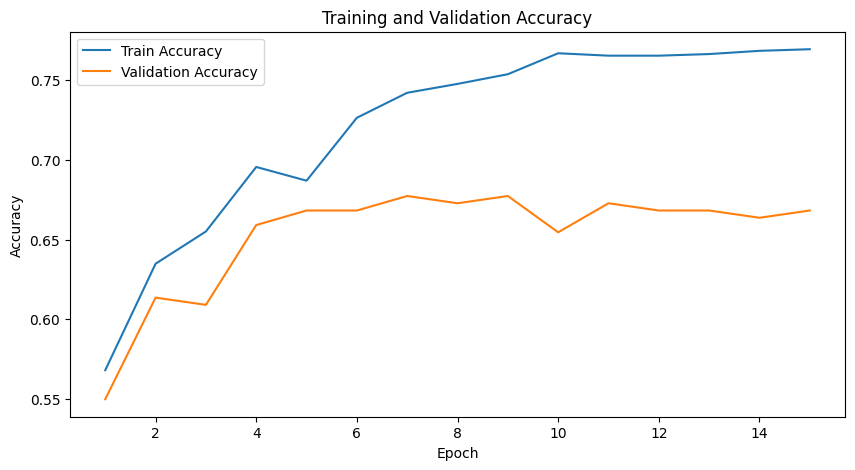

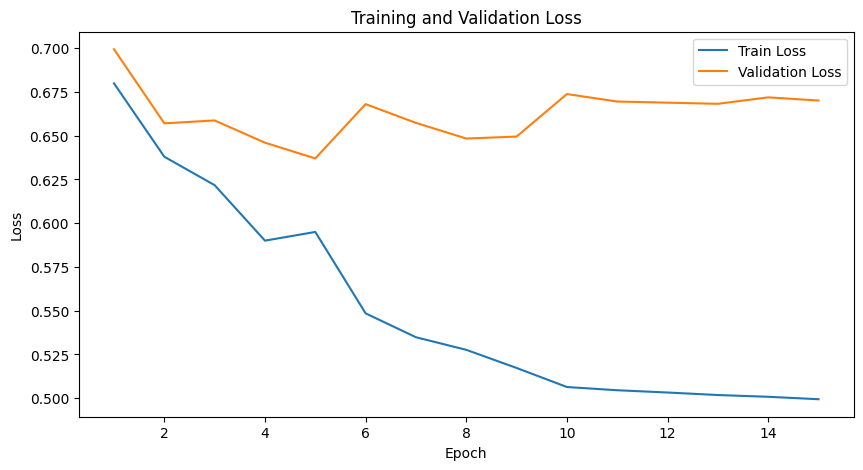

In [ ]:

warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5))
plt.plot(epoches_3, train_acc_hist_3, label='Train Accuracy')
plt.plot(epoches_3, val_acc_hist_3, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()





warnings.filterwarnings("ignore")
plt.figure(figsize=(10,5))
plt.plot(epoches_3, train_loss_hist_3, label='Train Loss')
plt.plot(epoches_3,val_loss_hist_3, label="Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = score(model3,test_loader)
print("test loss",test_loss)
print("test accuracy",float(test_accuracy))

test loss 0.6112447958439589
test accuracy 0.6730000376701355


#Expierement 4- Siamese Neural Networks, Adam optimizer, schdualer and regularization

In [ ]:
train_loss_hist_4, val_loss_hist_4, train_acc_hist_4, val_acc_hist_4,epoches_4,model4 = main(SiameseModel(), 64, 0.001, 100,'Adam')

Epoch [1/100], Train Loss: 0.6916787624359131, Train Accuracy: 0.5550505518913269, Val Loss: 0.6791706681251526, Val Accuracy: 0.5636363625526428
Epoch [2/100], Train Loss: 0.6194935287198713, Train Accuracy: 0.6560606360435486, Val Loss: 0.657661184668541, Val Accuracy: 0.581818163394928
Epoch [3/100], Train Loss: 0.6534281796024691, Train Accuracy: 0.6237373948097229, Val Loss: 0.6618605107069016, Val Accuracy: 0.6090908646583557
Epoch [4/100], Train Loss: 0.6197274769506147, Train Accuracy: 0.660101056098938, Val Loss: 0.6510998904705048, Val Accuracy: 0.6499999761581421
Epoch [5/100], Train Loss: 0.6214631411337084, Train Accuracy: 0.6464647054672241, Val Loss: 0.697723776102066, Val Accuracy: 0.5727272629737854
Epoch [6/100], Train Loss: 0.5753304987184463, Train Accuracy: 0.7020202279090881, Val Loss: 0.6491010189056396, Val Accuracy: 0.6454545259475708
Epoch [7/100], Train Loss: 0.5650578573826821, Train Accuracy: 0.718181848526001, Val Loss: 0.6416664123535156, Val Accuracy: 0.

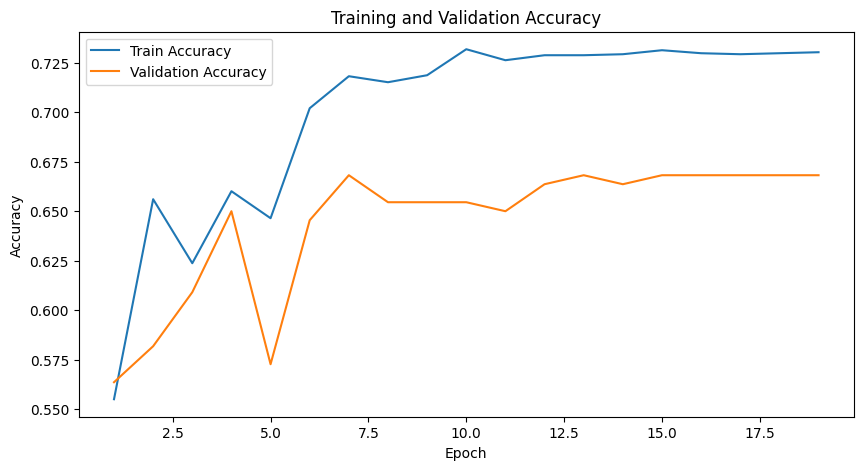

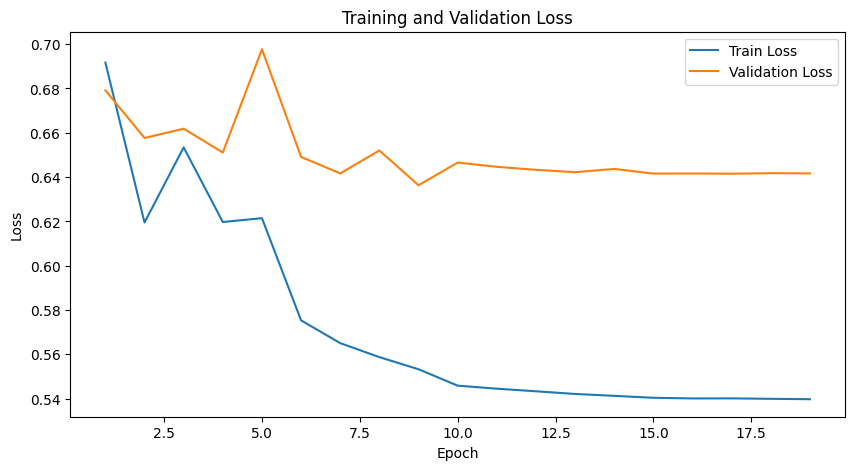

In [ ]:

warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5))
plt.plot(epoches_4, train_acc_hist_4, label='Train Accuracy')
plt.plot(epoches_4, val_acc_hist_4, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()





warnings.filterwarnings("ignore")
plt.figure(figsize=(10,5))
plt.plot(epoches_4, train_loss_hist_4, label='Train Loss')
plt.plot(epoches_4,val_loss_hist_4, label="Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = score(model4,test_loader)
print("test loss",test_loss)
print("test accuracy",float(test_accuracy))

test loss 0.5935049690306187
test accuracy 0.6760000586509705


#Expierement 5- Siamese Neural Networks  with Adam optimizer, schdualer,regularization and dropout

In [ ]:
class SiameseModelDropOut(nn.Module):
    def __init__(self):
        super(SiameseModelDropOut, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=10, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=1),
            nn.ReLU(),

        )

        self.flatten = Flatten()
        self.fc1 = nn.Linear(9216, 32, bias=True)
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        self.apply(init_weights)

    def forward(self, one, two):
        image1 = self.conv1(one)
        image1 = self.conv2(image1)
        image1 = self.conv3(image1)
        image1 = self.conv4(image1)
        image1 = self.flatten(image1)
        image1 = self.fc1(image1)

        image2 = self.conv1(two)
        image2 = self.conv2(image2)
        image2 = self.conv3(image2)
        image2 = self.conv4(image2)
        image2 = self.flatten(image2)
        image2 = self.fc1(image2)

        final = self.fc2(torch.abs(image1 - image2))
        final = self.sigmoid(final)
        return final

In [ ]:
train_loss_hist_5, val_loss_hist_5, train_acc_hist_5, val_acc_hist_5,epoches_5,model5 = main(SiameseModelDropOut(), 64, 0.001, 100,'Adam')

Epoch [1/100], Train Loss: 0.6871365558716559, Train Accuracy: 0.5752525329589844, Val Loss: 0.6700567901134491, Val Accuracy: 0.5454545021057129
Epoch [2/100], Train Loss: 0.6343042119856803, Train Accuracy: 0.6343434453010559, Val Loss: 0.6793090552091599, Val Accuracy: 0.5999999642372131
Epoch [3/100], Train Loss: 0.616884869913901, Train Accuracy: 0.6671717762947083, Val Loss: 0.6465025395154953, Val Accuracy: 0.6454545259475708
Epoch [4/100], Train Loss: 0.615710235411121, Train Accuracy: 0.65505051612854, Val Loss: 0.6640912145376205, Val Accuracy: 0.6318181753158569
Epoch [5/100], Train Loss: 0.6214582939301768, Train Accuracy: 0.665656566619873, Val Loss: 0.6284872591495514, Val Accuracy: 0.6454545259475708
Epoch [6/100], Train Loss: 0.5792656656234495, Train Accuracy: 0.7126262784004211, Val Loss: 0.6165962815284729, Val Accuracy: 0.6954545378684998
Epoch [7/100], Train Loss: 0.5659311750242787, Train Accuracy: 0.7247474789619446, Val Loss: 0.6083075255155563, Val Accuracy: 0.

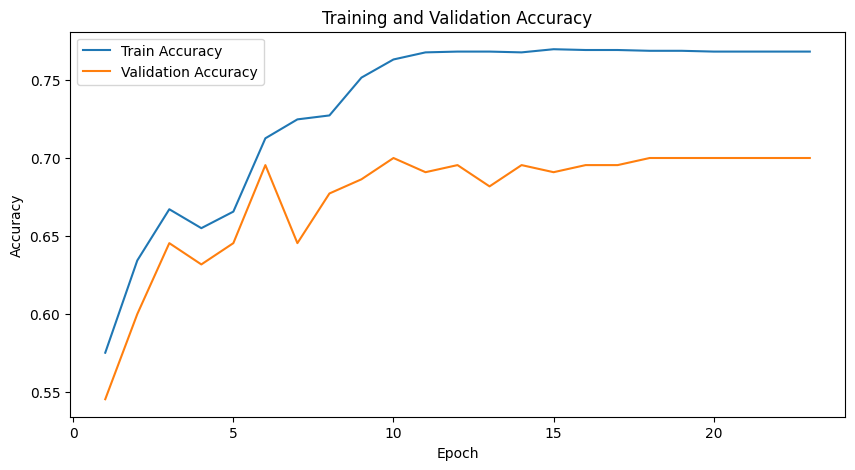

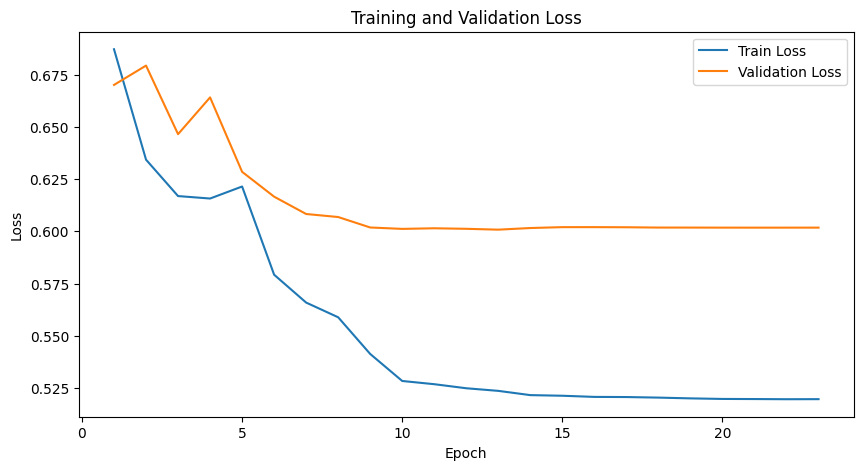

In [ ]:
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5))
plt.plot(epoches_5, train_acc_hist_5, label='Train Accuracy')
plt.plot(epoches_5, val_acc_hist_5, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()





warnings.filterwarnings("ignore")
plt.figure(figsize=(10,5))
plt.plot(epoches_5, train_loss_hist_5, label='Train Loss')
plt.plot(epoches_5,val_loss_hist_5, label="Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = score(model5,test_loader)
print("test loss",test_loss)
print("test accuracy",float(test_accuracy))

test loss 0.6008008010685444
test accuracy 0.706000030040741


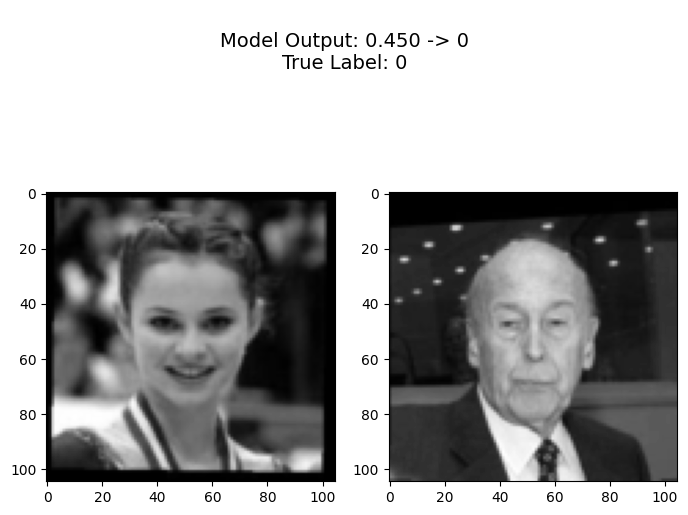

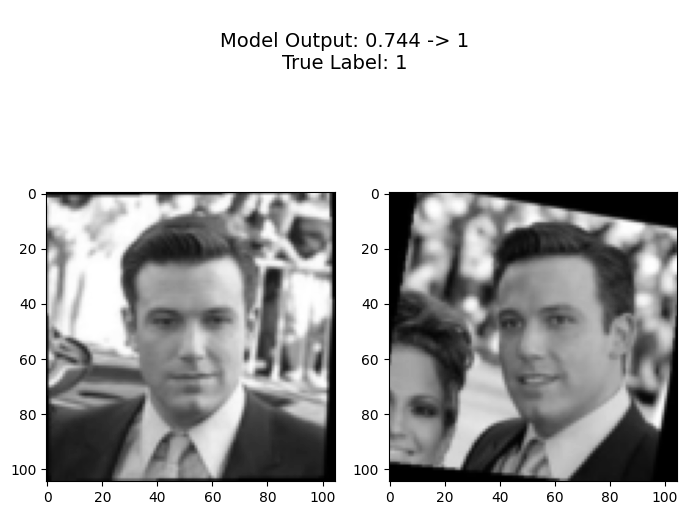

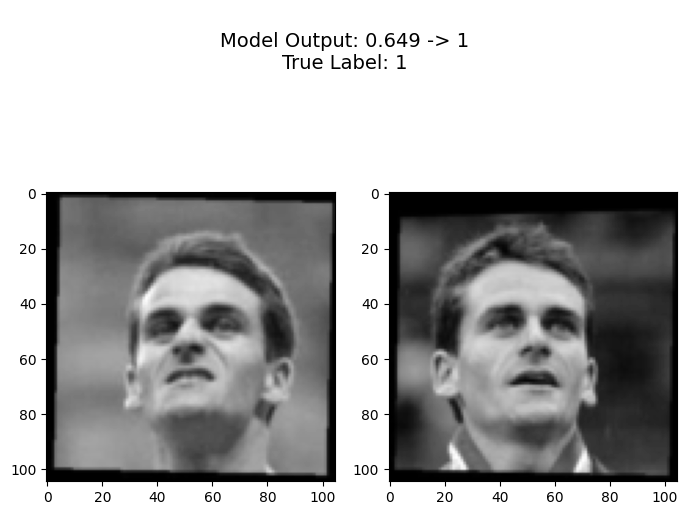

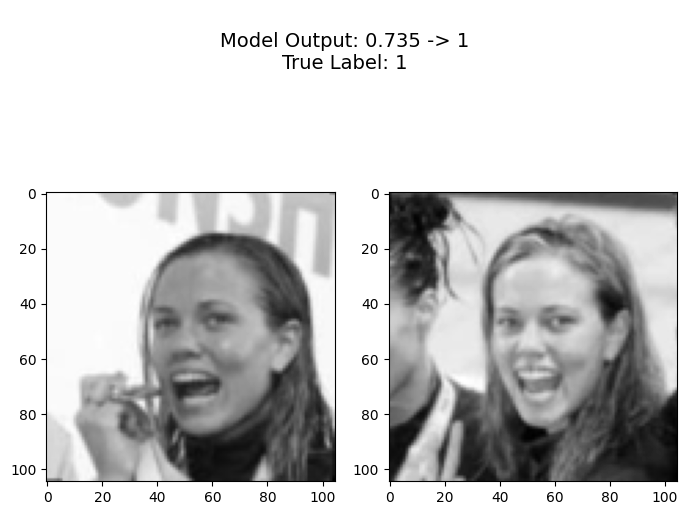

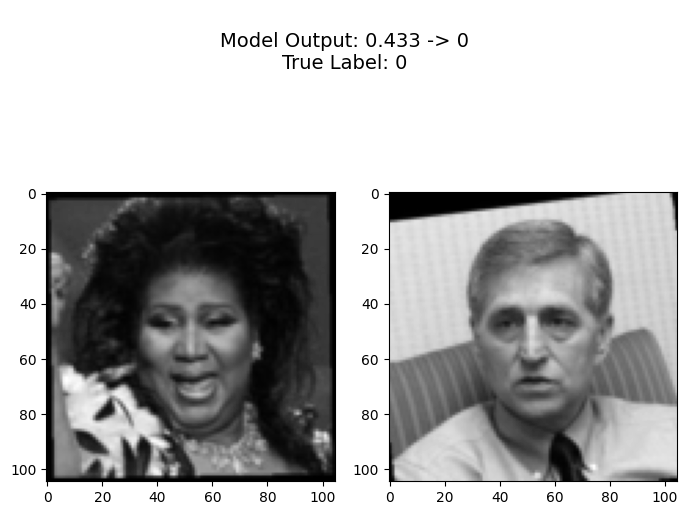

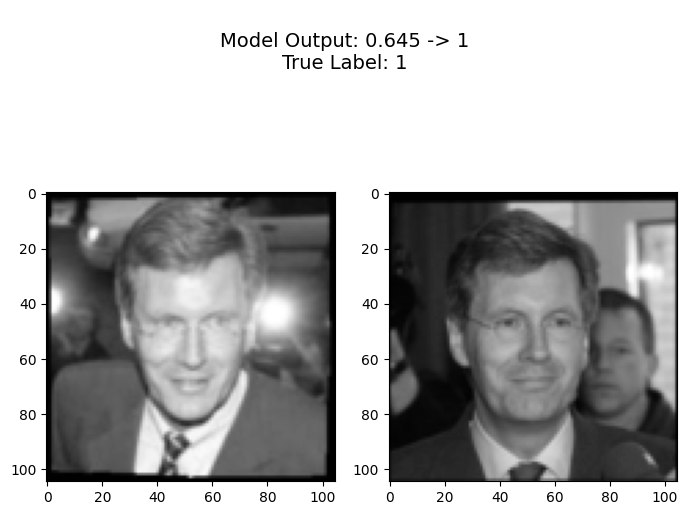

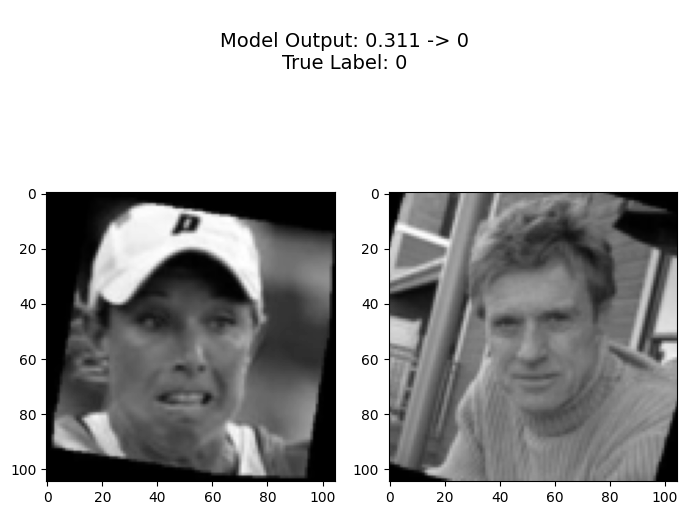

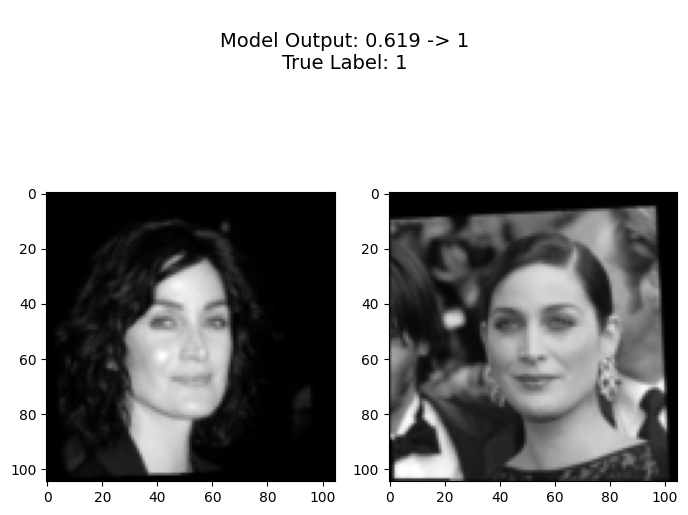

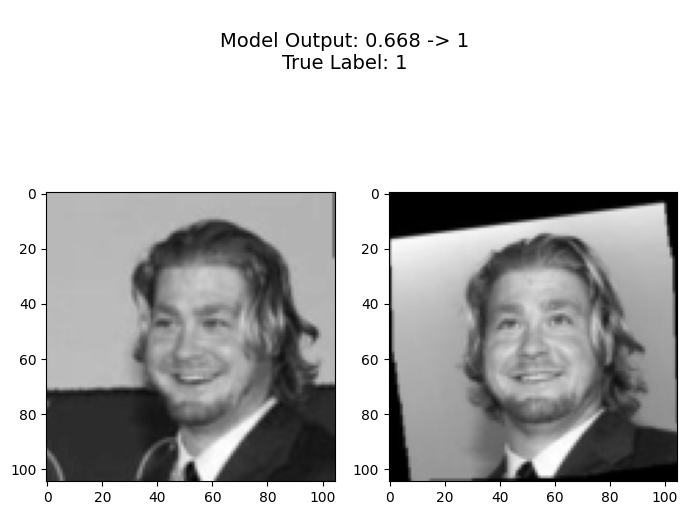

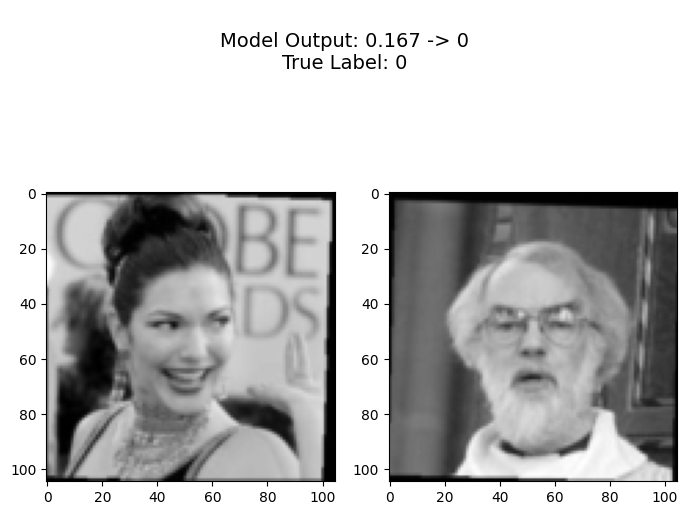

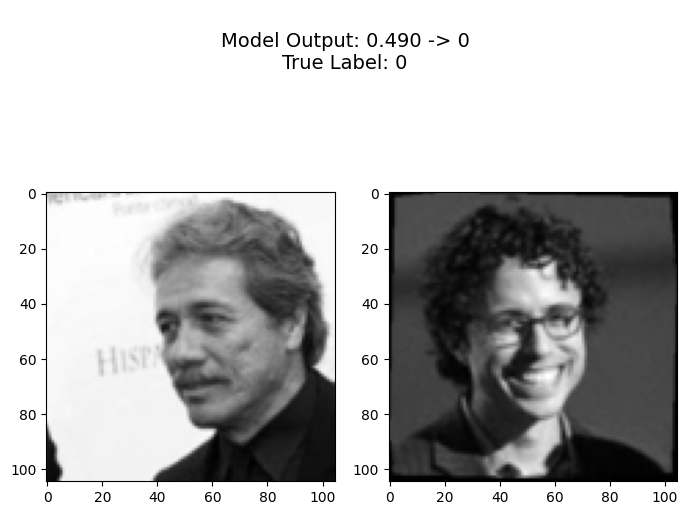

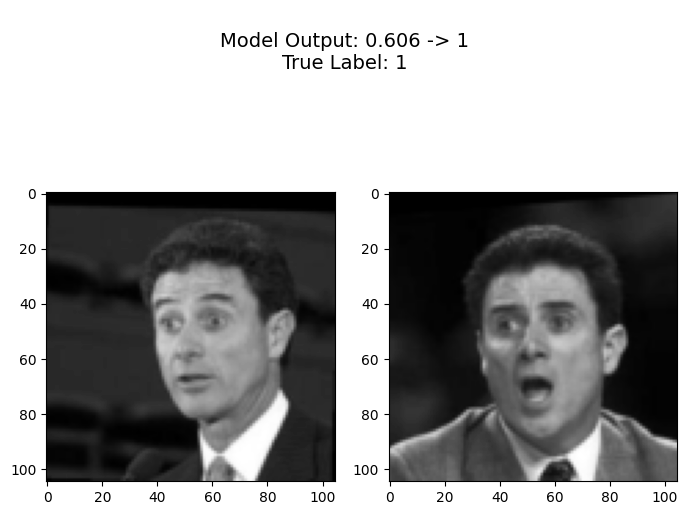

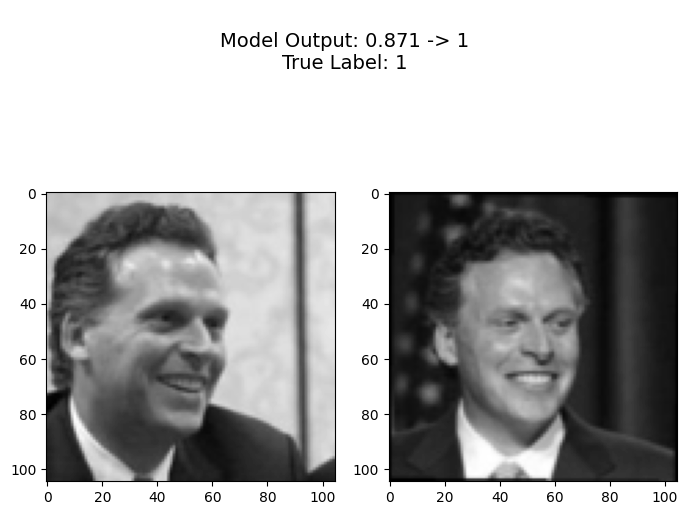

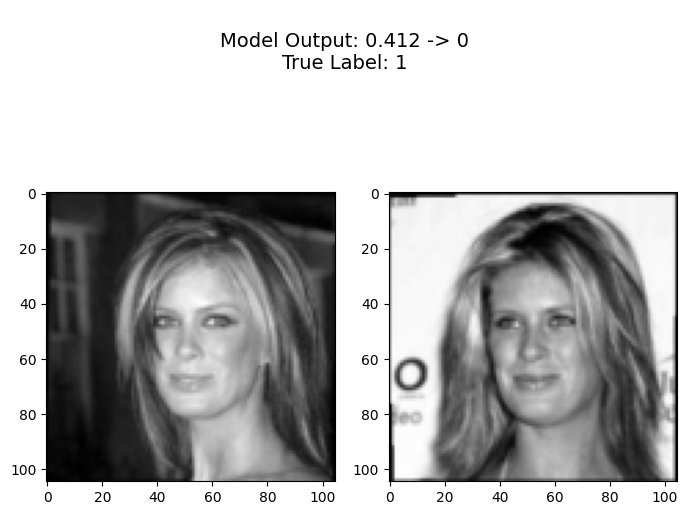

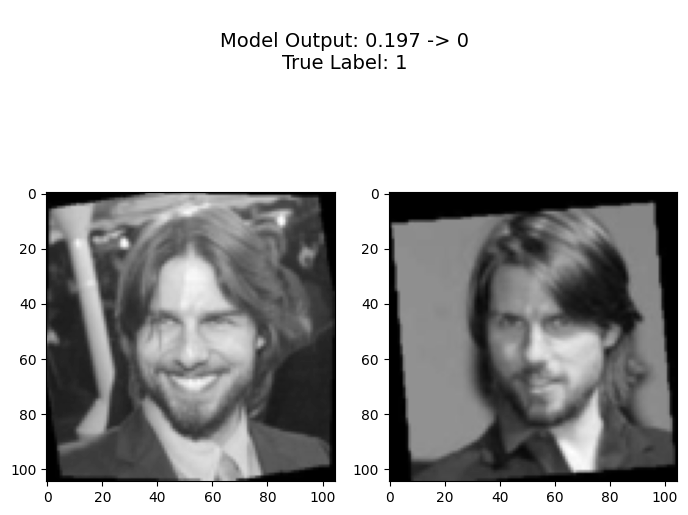

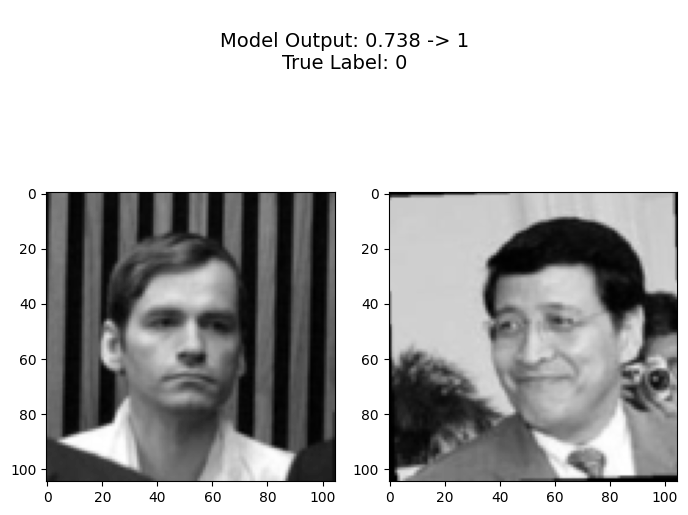

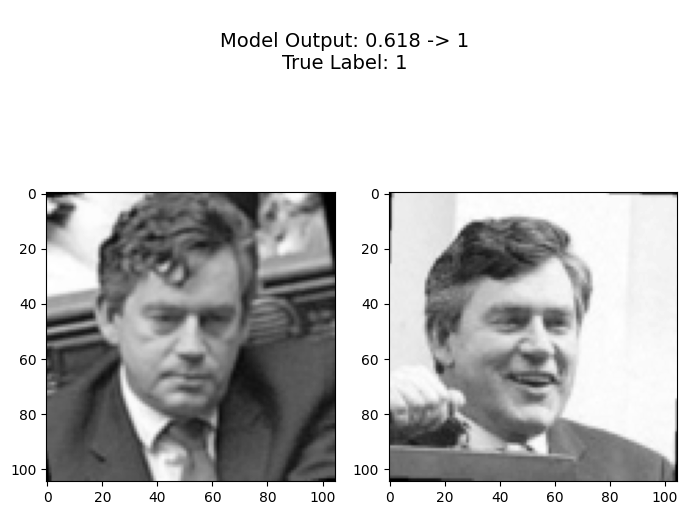

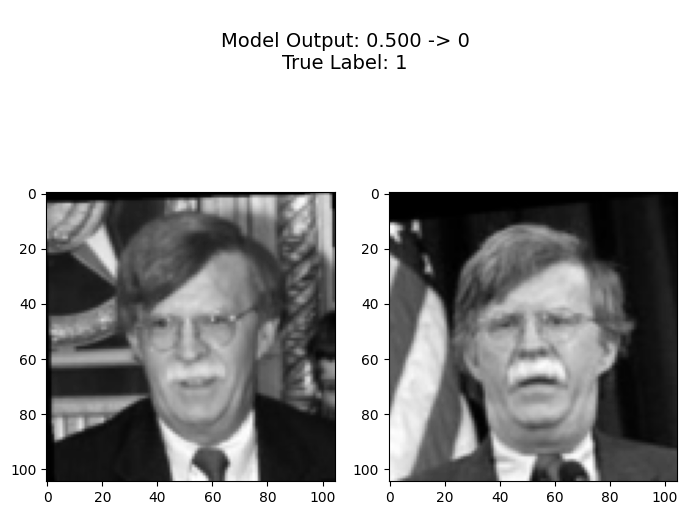

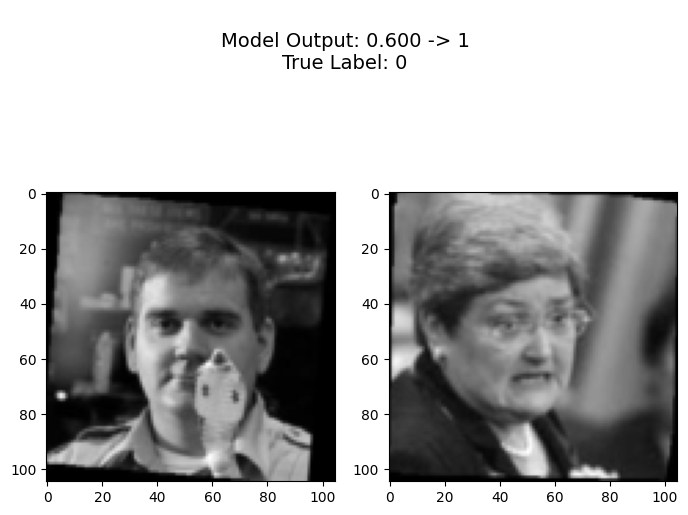

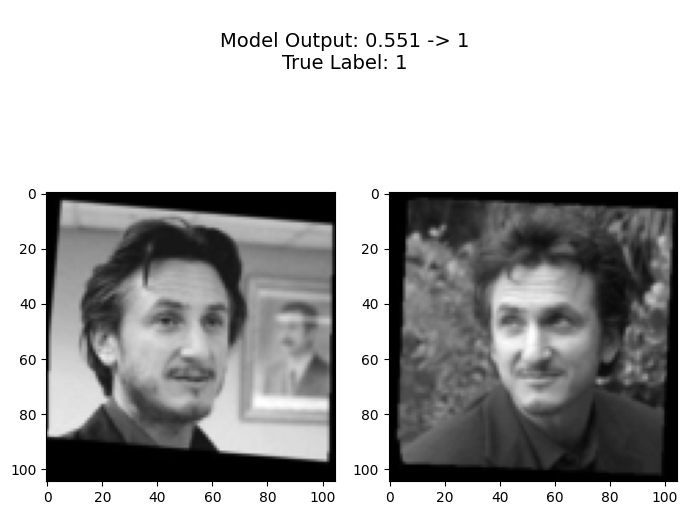

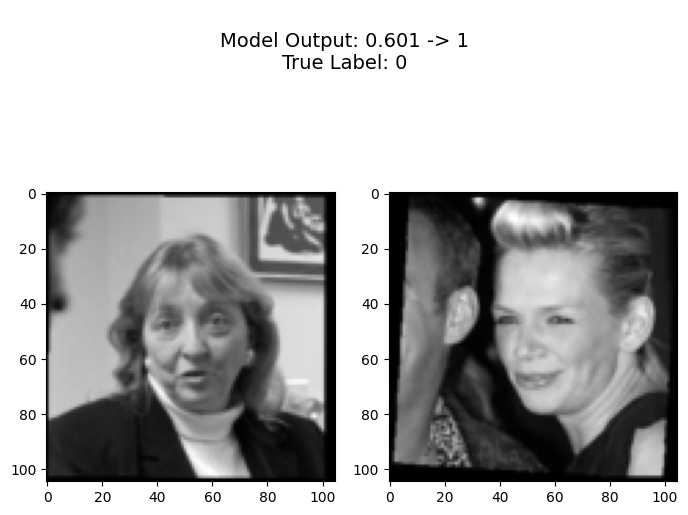

In [ ]:
import torch
import matplotlib.pyplot as plt
torch.manual_seed(25)
random.seed(25)
np.random.seed(25)
def plot_images_with_prediction(model, image1, image2, true_label):
    image1, image2, true_label = image1.cuda(), image2.cuda(),  true_label.cuda()
    first_image_cpu, second_image_cpu = image1[0].cpu(), image2[0].cpu()

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(7, 6)
    ax1.imshow(first_image_cpu.numpy()[0], cmap='gray')
    ax2.imshow(second_image_cpu.numpy()[0], cmap='gray')

    model_output = model5(image1, image2)
    pred_value = round(float(model_output[0]), 3)
    pred_class = 1 if pred_value > 0.5 else 0

    title =  "\nModel Output: {:.3f} -> {}\nTrue Label: {}".format(pred_value, pred_class, int(true_label))
    fig.suptitle(title, fontsize=14)

    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_dataloader):
    for i, (img1, img2, label) in enumerate(test_dataloader):
        plot_images_with_prediction(model, img1, img2, label)
        if i >= 20:
            break


test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
evaluate_model(model5, test_dataloader)
